# COSE FATTE E TESTATE
- I dati considerati sono riferiti a pazienti affetti da BRCA, prendendo dati di sequenziamento sia di miRNA che di mRNA.
- Provato a vedere se ci fosse senale tra sequenze di miRNA e 'age_at_initial_pathologic_giagnosis': abbiamo provato con reti semplici lineari a 3 e 5 stati densi, ma entrambe restituivano metriche di valutazione con valori sotto quelli di un random guesser, quindi sotto consiglio della prof abbiamo lasciato perdere.
- Sempre sotto consiglio della prof abbiamo quindi cambiato ambito di ricerca, e siamo passati all'analisi di survivability nei pazienti, che è un ambito in cui c'è già un po' di letteratura e un abbastanza consolidato, seppur fresco, stato dell'arte, per le sequenze di mRNA. Il nostro obbiettivo è diventato quindi di vedere se è possibile fare lo stesso con dati di miRNA. 
- Abbiamo svolto una prima fase di preparazione e pulizia dei dati composta da: una eliminazione di colonne inutili, one-hot encoding delle colonne utili categoriche, eliminazione di outliers per quanto riguarda l'età del campione selezionato, eliminazione dei pazienti che non sono morti e non hanno un 'days_to_last_followup' "alto" (calcolato come 25 esimo percentile dei 'days_to_death'). 
- Abbiamo poi applicato diverse tecniche di normalizzazione dei dati in base anche alla loro sorgente, nello specifico: per quanto riguarda miRNA abbiamo creato un primo dataset normalizzanto tramite log2 e un altro normalizzato per quantile, mentre per mRNA abbiamo anche in questo caso creato un primo dataset normalizzato tramite solo log2, e un altro invece usando i valori già disponibili normalizzati tramite TPM. Abbiamo creato così 4 dataset diversi da testare
- Un ultimo processamento dei dati fatto prima di salvare effettivamente il dataset normalizzato è stato quello di eliminare le colonne con una varianza molto bassa, usando come threshold il 50-esimo percentile. 
- Queste pratiche sono state svolte nel caso delle righe per eliminare dati rumorosi, ovvero possibili outliers principalmente, e per il caso delle colonne, per fare una prima scrematura e ridurre l'elevato numero di features dei dati genetici. 
- L'ultimo step di preparazione dei dati è stato quello di applicare uno standard scaler sulle features genetiche e l'età di inizio diagnosi, per portare i valori a media 0 e deviazione standard unitaria. Sono state lasciate quindi invariate praticamente le colonne di stadio del tumore che avevano subito un one-hot encoding.
- Abbiamo definito 3 approcci diversi poi per trattare questi dataset e fare l'analisi di sopravvivenza, di complessità sempre crescente ma sempre basati su analisi tramite Cox:
    - Il primo modello è una semplice ElasticNet per implementare un modello di Cox penalizzato, con l'integrazione di una kernelPCA per la riduzione della dimensionalitò dell'input. Abbiamo scelto questa invece che un metodo di Lasso, in quanto Lasso presenta due principali svantaggi: il primo è che non può selezionare più features di quanti siano i samples all'interno del dataset, e il secondo, se i dati contengono un gruppo di features altamente correlate, LASSO selezionerebbe casualmente solo una tra queste. La penalità della Elastic Net risolve questi due problemiusando una combinazione pesata delle due penalità l_1 e l_2 risolvendo 
    
    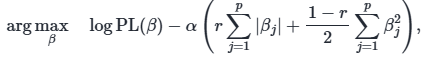

    La penalità di Elastic Net combina la proprietà di selezione del subset di LASSO con la forza di regolarizzazione di Ridge. Con questo approccio la pipeline di esecuzione è:
    
    1. Gridsearch per trovare i migliori parametri per ElasticNet tra l1_ratio, alpha_min_ratio. Successivamente trovati questi facciamo un altro GridSearch (Randomized per leggerezza) per trovare il miglior fattore di penalizzazione alpha per le sole colonne genetiche. Selezioniamo in realtà 2 candidati per questo parametro, il primo che è quello suggerito dal grdisearch automaticamente e il secondo filtrato usando un criterio custom che va a prediligere un alpha che mantenga un numero di colonne con peso non nullo tra le 100 e le 200, e che minimizzi anche la metrica di scoring, che per entrambe le search è il concordance-index. In caso nessun alpha che soddisfi il requisito del numero di colonne sia trovato, viene preso l'alpha che mantiene il minor un numero di colonne attive sopra a un certo limite inferiore "basso" (50).
    2. Trovato il best set di features genetiche, questo sub set di colonne viene processato tramite PCA per applicare una ulteiore riduzione di dimensionalità per portarle a 50.
    3. Si ricostruisce il dataset concatenando le colonne cliniche a quelle processate da PCA, e viene dato in input infine di nuovo a una nuova Elastic Net che viene addestrata e cross validata, da cui si estraggono i risultati di analisi di sopravvivenza
    - Il secondo approccio usa invece una PCA, questa volta lineare, per applicare la riduzione di dimensionalità, e ridurre quindi sempre le colonne genetiche a 50 componenti, per poi passare il dataset composto dalla concatenazione delle colonne cliniche e le componenenti genetiche a una rete neurale DeepSurv. In particolare proviamo sia una testata DeepSurv a 3 layer che una a 5 layer, per testare se l'aumento di complessità aiuta l'analisi o porta invece solo a un overfitting. 
    - L'ultimo approccio prevede di sostituire alla PCA un Variational Auto Encoder per fare riduzione di dimensionalità sulle colonne gentiche, per poi di nuovo passare il dataset ottenuto concatenando queste nuove componenti con i dati clinici a una testata DeepSurv a 3 e 5 layer. 

    Ognuno di questi approcci è stato testato su ognuno dei 4 possibili dataset che abbiamo generato nella fase di preparazione e preprocessing.

- Abbiamo sempre usato come principale metrica di valutazione dei modelli il concordance index, proponendo un box plot per mostrarne l'andamento per ognuno dei test eseguiti per ogni approccio.
- Mostriamo anche il Brier Score over time per visualizzare se la sicurezza di predizione dei modelli ha una andamento coerente, insieme all'Integrated Brier Score
- Per l'approccio basato su ElasticNet viene anche visualizzato un grafico che mostra per l'alpha selezionato, qual'è stato il concordance index corrispondente in fase di ricerca. Questo grafico viene fatto per mostrare se la scelta di un alpha differente, scelto tramite un filtro diverso dalla solo massimizzazione del C-index, porti a risultati migliori.
- Per l'approccio basato su Elastic Net viene mostrato un grafico che mostra i coefficienti assegnati alle varie features tenute dopo la prima selezione e la PCA, mentre per gli approcci basati su DeepSurv viene fatto il grafico delle colonne più rilevanti secondo la PCA, ovvero quelle con maggior varianza.
- Per i soli approcci basati su DeepSurv viene anche mostrato un grafico riguardanti i valori SHAP calcolati sulle colonne del dataset processato e ridotto


# Risultati e conclusioni

- ElasticNet Cox: 
    - I risultati migliori per miRNA si osservano con normalizzazione con log2 e alpha filtrato, per mRNA invece c'è poca differenza tra usare dati normalizzati a TPM o log2, che producono entrambi ottimi risultati. Nonostante i le performance con miRNA siano inferiori rispetto a quelle usando mRNA, sono comunque molto buone
    - Per il miRNA l'Integrated Brier Sscore migliore si ottiene sempre nel caso di dati normalizzati a log2 con alpha filtrato, mentre per mRNA ancora si ha poca differenza usando alpha filtrato tra usare dati con TPM o log2. Si nota inoltre poca differenza in questo caso nell'IBS tra best miRNA e best mRNA, entrambi che si aggirano intorno allo 0.07~0.08 con deviazione standard 0.02~0.03
    - 
